In [2]:
!git clone https://github.com/dalmia/David-Silver-Reinforcement-learning.git

Cloning into 'David-Silver-Reinforcement-learning'...
remote: Enumerating objects: 346, done.
remote: Total 346 (delta 0), reused 0 (delta 0), pack-reused 346 (from 1)
Receiving objects: 100% (346/346), 22.39 MiB | 21.79 MiB/s, done.
Resolving deltas: 100% (160/160), done.


In [12]:
%matplotlib inline

import gym
import itertools
import matplotlib
import numpy as np
import pandas as pd
import sys

if "/content/David-Silver-Reinforcement-learning" not in sys.path:
  sys.path.append("/content/David-Silver-Reinforcement-learning")

from collections import defaultdict
from lib.envs.windy_gridworld import WindyGridworldEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [13]:
env = WindyGridworldEnv()

In [14]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.

    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.

    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.

    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [15]:
def sarsa(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    """
    SARSA algorithm: On-policy TD control. Finds the optimal epsilon-greedy policy.

    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.

    Returns:
        A tuple (Q, stats).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """

    # Number of actions
    nA = env.action_space.n

    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))

    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)


    for i_episode in range(num_episodes):

        # GLIE criteria
        epsilon /= (i_episode + 1)

        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes))
            sys.stdout.flush()

        state = env.reset()
        terminated = False

        for t in itertools.count():

            # sample action following epsilon greedy policy
            action = np.random.choice(nA, p=policy(state))

            # Perform the action -> Get the reward and observe the next state
            new_state, reward, terminated, _ = env.step(action)

            # Choose the action for the next state following our current policy
            next_action = np.random.choice(nA, p=policy(new_state))

            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t

            # value that we should have got
            td_target = reward + discount_factor * Q[new_state][next_action]
            td_error = td_target - Q[state][action]

            # SARSA update
            Q[state][action] += alpha * td_error

            # Update current state
            state = new_state

            if terminated:
                break

    return Q, stats

In [16]:
Q, stats = sarsa(env, 200)

Episode 100/200.
Episode 200/200.


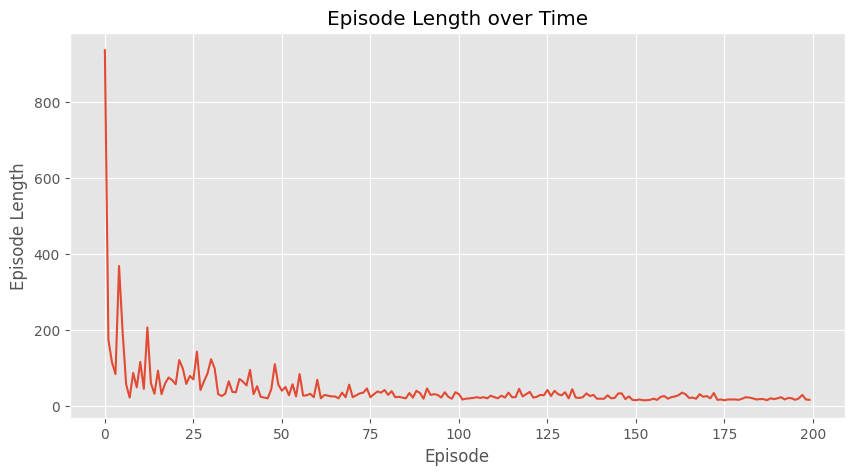

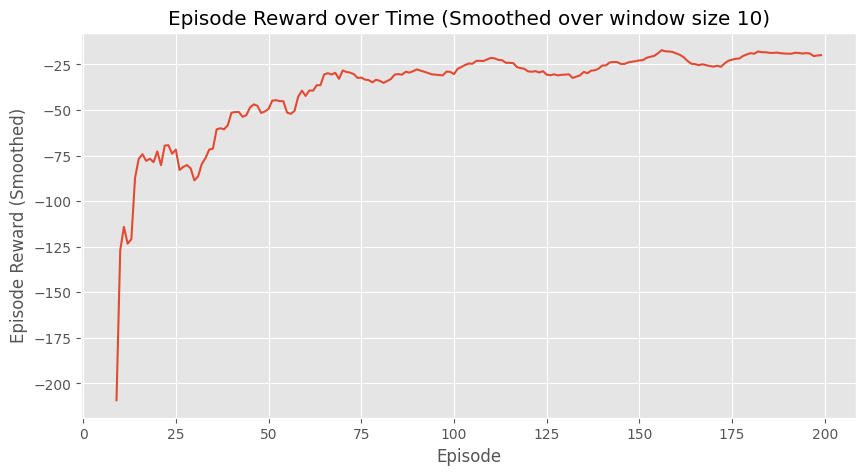

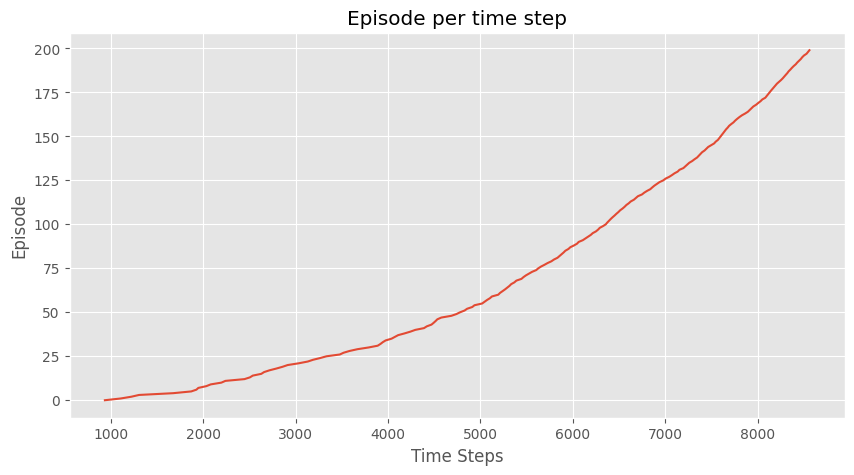

(<Figure size 1000x500 with 1 Axes>,
 <Figure size 1000x500 with 1 Axes>,
 <Figure size 1000x500 with 1 Axes>)

In [17]:
plotting.plot_episode_stats(stats)